In [1]:
# Check GPU
!nvidia-smi


Wed Nov 29 02:52:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [13]:
import os
from torchvision import datasets,transforms
from torch.utils.data import DataLoader



In [15]:
train_dir = '/content/drive/MyDrive/Pet_Facial/Master Folder/train'
test_dir = '/content/drive/MyDrive/Pet_Facial/Master Folder/test'

In [14]:
NUM_WORKERS = os.cpu_count()


In [16]:
def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  class_names = train_data.classes

  # Generate data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names


In [17]:

IMG_SIZE = 224
#manual pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [18]:

BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x791049401f60>,
 ['Angry', 'Other', 'Sad', 'happy'])

torch.Size([3, 224, 224]) tensor(3)


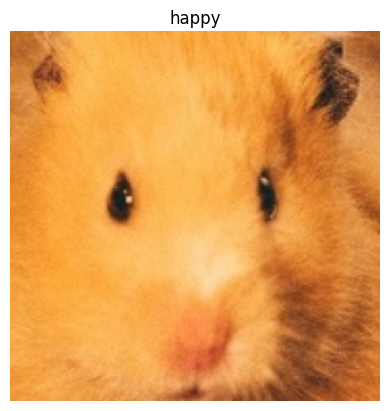

In [19]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [20]:

class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        self.flatten = nn.Flatten(start_dim=2, 
                                  end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1) 

In [21]:

patch_size =16

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)



set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) 
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [22]:
print(patch_embedded_image)

tensor([[[-0.6073,  0.0744, -0.0712,  ...,  0.3104, -0.2867,  0.2044],
         [-0.8203,  0.0905, -0.0696,  ...,  0.4386, -0.3419,  0.2458],
         [-0.8362,  0.1288, -0.1230,  ...,  0.5056, -0.4182,  0.3030],
         ...,
         [-0.4180, -0.0201, -0.0566,  ...,  0.2368, -0.2420,  0.1525],
         [-0.5728,  0.0288, -0.0215,  ...,  0.3139, -0.2601,  0.1540],
         [-0.6404,  0.0575, -0.1019,  ...,  0.3313, -0.3098,  0.2119]]],
       grad_fn=<PermuteBackward0>)


In [23]:
set_seeds()

patch_size = 16

print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")



batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) 
print(f"Class token embedding shape: {class_token.shape}")

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) 


patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

print(patch_embedding_class_token)  

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.6073,  0.0744, -0.0712,  ...,  0.3104, -0.2867,  0.2044],
         [-0.8203,  0.0905, -0.0696,  ...,  0.4386, -0.3419,  0.2458],
         ...,
         [-0.4180, -0.0201, -0.0566,  ...,  0.2368, -0.2420,  0.1525],
         [-0.5728,  0.0288, -0.0215,  ...,  0.3139, -0.2601,  0.1540],
         [-0.6404,  0.0575, -0.1019,  ...,  0.3313, -0.3098,  0.2119]]],
       grad_fn=<CatBackward0>)


In [24]:

class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 attn_dropout:float=0): 
        super().__init__()

        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) 

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x, 
                                             value=x, 
                                             need_weights=False) 
        return attn_output

In [25]:

class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    def __init__(self,
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 dropout:float=0.1): 
        super().__init__()

        
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, 
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout) 
        )

    
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [26]:

class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    
    def __init__(self,
                 embedding_dim:int=768, 
                 num_heads:int=12, 
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()

        
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    
    def forward(self, x):

        
        x =  self.msa_block(x) + x

        
        x = self.mlp_block(x) + x

        return x


In [28]:
!pip install torchinfo

In [29]:
transformer_encoder_block = TransformerEncoderBlock()

from torchinfo import summary

summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [30]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    
    def __init__(self,
                 img_size:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 num_transformer_layers:int=12, 
                 embedding_dim:int=768, 
                 mlp_size:int=3072, 
                 num_heads:int=12, 
                 attn_dropout:float=0, 
                 mlp_dropout:float=0.1, 
                 embedding_dropout:float=0.1, 
                 num_classes:int=1000): 
        super().__init__() 

        
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

       
        self.num_patches = (img_size * img_size) // patch_size**2

        
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    
    def forward(self, x):

        
        batch_size = x.shape[0]

        
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        
        x = self.patch_embedding(x)

        
        x = torch.cat((class_token, x), dim=1)

        
        x = self.position_embedding + x

        
        x = self.embedding_dropout(x)

        
        x = self.transformer_encoder(x)

        
        x = self.classifier(x[:, 0]) 

        return x

In [31]:
vit = ViT(num_classes=len(class_names))

In [36]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cuda


In [52]:
from going_modular.going_modular import engine

# Setup the optimizer 
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k

# Setup the loss function 
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()

# Train the model 
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3866 | train_acc: 0.2295 | test_loss: 1.3880 | test_acc: 0.0938
Epoch: 2 | train_loss: 1.3865 | train_acc: 0.2412 | test_loss: 1.3858 | test_acc: 0.1562
Epoch: 3 | train_loss: 1.3866 | train_acc: 0.2227 | test_loss: 1.3845 | test_acc: 0.5781
Epoch: 4 | train_loss: 1.3870 | train_acc: 0.2393 | test_loss: 1.3868 | test_acc: 0.0938
Epoch: 5 | train_loss: 1.3867 | train_acc: 0.2412 | test_loss: 1.3851 | test_acc: 0.5781
Epoch: 6 | train_loss: 1.3865 | train_acc: 0.2402 | test_loss: 1.3844 | test_acc: 0.5781
Epoch: 7 | train_loss: 1.3868 | train_acc: 0.2432 | test_loss: 1.3888 | test_acc: 0.1562
Epoch: 8 | train_loss: 1.3867 | train_acc: 0.2246 | test_loss: 1.3875 | test_acc: 0.1719
Epoch: 9 | train_loss: 1.3866 | train_acc: 0.2275 | test_loss: 1.3873 | test_acc: 0.1562
Epoch: 10 | train_loss: 1.3865 | train_acc: 0.2354 | test_loss: 1.3880 | test_acc: 0.0938
Epoch: 11 | train_loss: 1.3865 | train_acc: 0.2471 | test_loss: 1.3909 | test_acc: 0.0938
Epoch: 12 | train_l

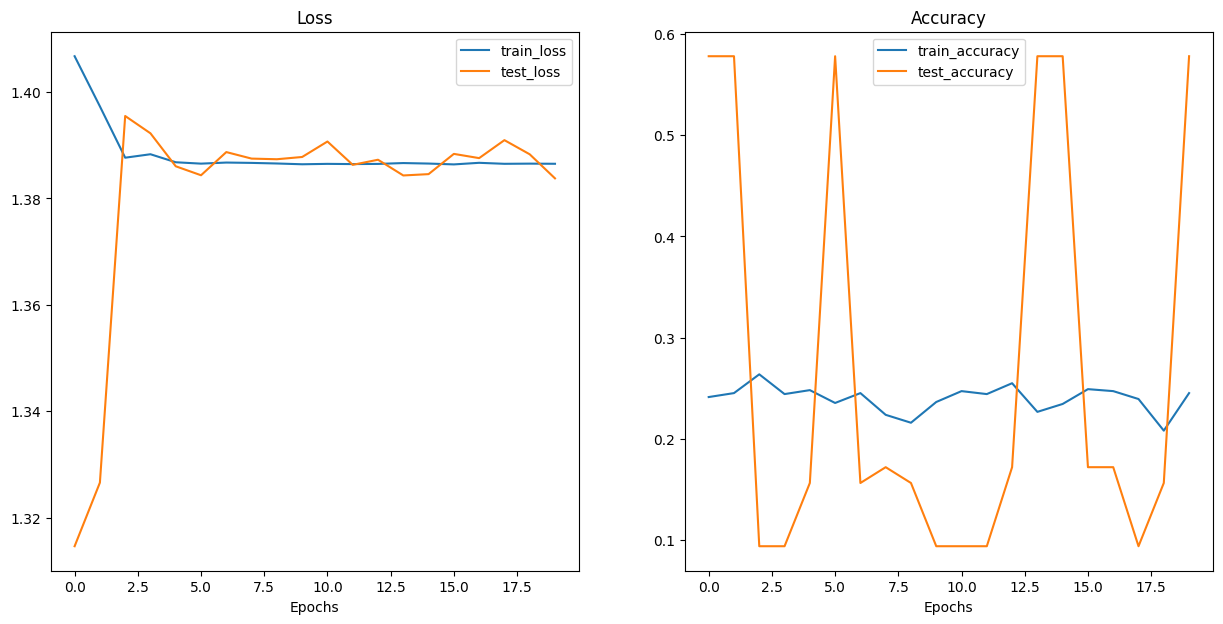

In [45]:

from helper_functions import plot_loss_curves


plot_loss_curves(results)

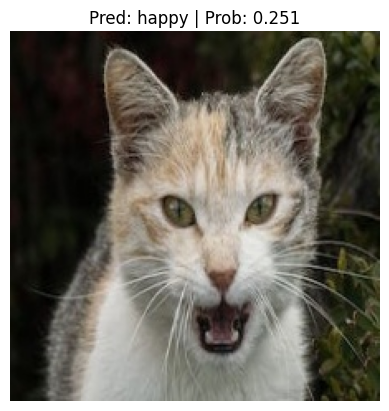

In [51]:
import requests


from going_modular.going_modular.predictions import pred_and_plot_image


custom_image_path = "/content/drive/MyDrive/Pet_Facial/Master Folder/test/Angry/14.jpg"

# Predict on custom image
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [47]:
torch.save(vit, 'vit_model_full.pth')
